# Decision Tree

## Data Preparation

The following steps were taken to prepare the data for modeling:

*   **Import Data:** The dataset was loaded from the CSV file.
*   **Correct Data Type & Handle Missing Values:** The `TotalCharges` column was converted from an `object` type to a `float`. Any missing values in `TotalCharges` were then imputed by calculating them based on the `MonthlyCharges` multiplied by the `tenure`.
*   **Remove Unnecessary Columns:** The `customerID` column was dropped, as it serves as a unique identifier and provides no predictive value for the model.

In [1]:
import pandas as pd
# 1. Load Data
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 2. Numeric Conversion
# The column ’TotalCharges ’ is read as object ( text ) because of empty strings.
# We convert it to numeric , coercing errors to NaN and then fill 'TotalCharges' = 'Tenure' * 'MonthlyCharge'.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors = 'coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df ['tenure'])

# 3. Drop identifier column
df = df.drop('customerID', axis=1)

## Model Preparation and Training

For the Decision Tree Classifier, data encoding was performed to improve model accuracy. Subsequently, the dataset was split into two parts: a training set and a testing set. Each set was used separately to help avoid overfitting.

In [2]:
from sklearn.model_selection import train_test_split

# 1. Targe Encoding
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 2. One-Hot Encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# 3. Split Data 
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Reserve 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Hyperparameter Tuning with Grid Search

To optimize the model, different hyperparameters were tested to find the combination that yields the most accurate F1 score. The F1 score is a crucial metric for this project because it provides a harmonic balance between precision and recall, which is important for making predictions on an imbalanced dataset like customer churn.

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# 1. Define parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],  
    'class_weight': ['balanced', None]
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1', n_jobs=-1)

grid_search.fit(X_train, y_train)

# 2. Best estimator from grid search
dt_optimized = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}


## Evaluation and Interpretation

The model was evaluated by comparing its performance on both the training and testing datasets. Analyzing the accuracy scores from both sets helps in understanding how well the model has learned and generalized from the data.

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Decision Tree Classifier - Optimized Model Results")
print("-" * 60)
# 1. Evaluate on Training Data 
print("TRAINING RESULTS\n")
y_pred_train = dt_optimized.predict(X_train)
print("Confusion Matrix (Train):\n", confusion_matrix(y_train, y_pred_train))
print("Classification Report (Train):\n", classification_report(y_train, y_pred_train))

print("-" * 60)

# 2. Evaluate on Test Data 
print("TESTING RESULTS\n")
y_pred_test = dt_optimized.predict(X_test)
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report (Test):\n", classification_report(y_test, y_pred_test))
print("-" * 60)


Decision Tree Classifier - Optimized Model Results
------------------------------------------------------------
TRAINING RESULTS

Confusion Matrix (Train):
 [[3042 1097]
 [ 220 1275]]
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.93      0.73      0.82      4139
           1       0.54      0.85      0.66      1495

    accuracy                           0.77      5634
   macro avg       0.74      0.79      0.74      5634
weighted avg       0.83      0.77      0.78      5634

------------------------------------------------------------
TESTING RESULTS

Confusion Matrix (Test):
 [[746 289]
 [ 80 294]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.79      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80    

In [5]:
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

Train Accuracy: 0.7662406815761449
Test Accuracy: 0.7381121362668559


### Feature Importance Plot

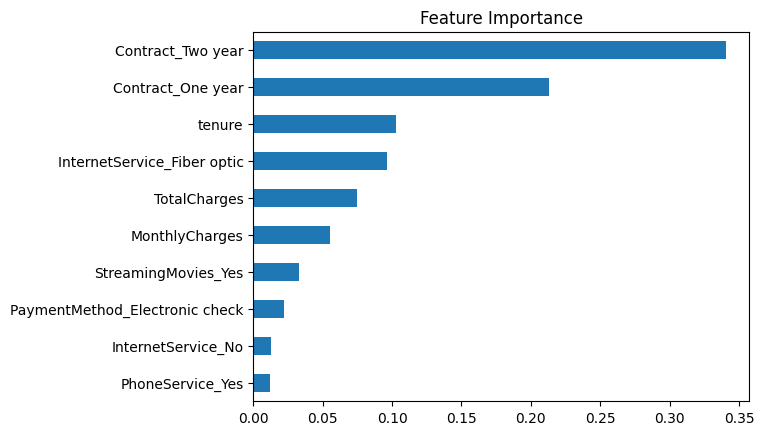

In [6]:
import matplotlib.pyplot as plt

# 1. Get the importance scores calculated by the tree
importances = pd.Series(dt_optimized.feature_importances_, index = X.columns)

# 2. plot
importances.nlargest(10).sort_values().plot(
    kind = 'barh',
    title = 'Feature Importance'
)

plt.show()


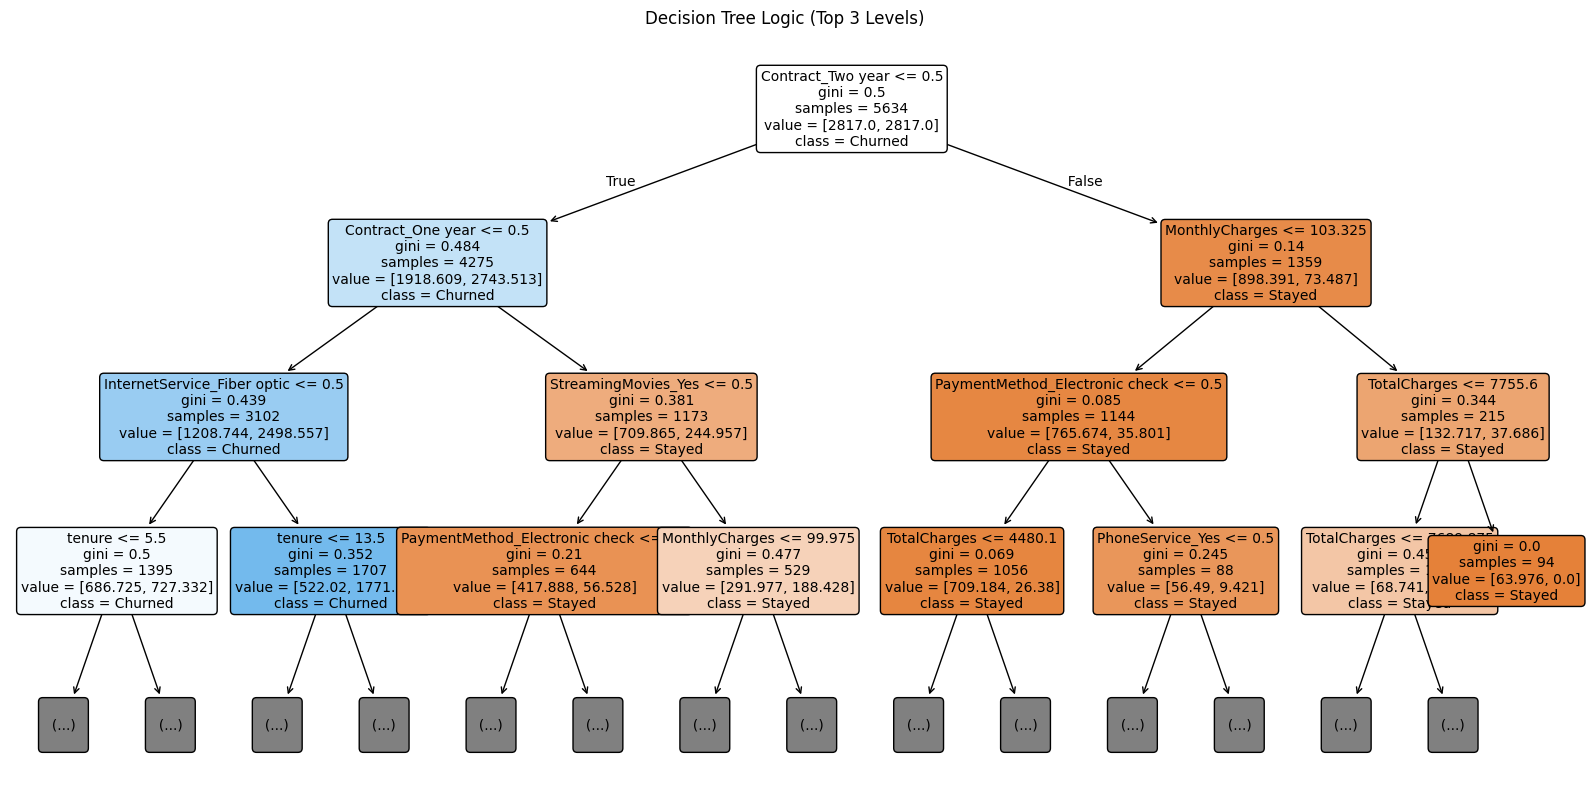

In [7]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt_optimized, 
          feature_names=X.columns,  
          class_names=['Stayed', 'Churned'], # Adjust based on your classes
          filled=True, 
          rounded=True, 
          max_depth=3,   # Limit depth so it's readable
          fontsize=10)
plt.title("Decision Tree Logic (Top 3 Levels)")
plt.show()

# Artificial Neural Network 

## Data Preparation

First, the necessary libraries were imported and the data was cleaned. As in the previous model, the `TotalCharges` column was converted to a numeric type, and any missing values were handled by multiplying `MonthlyCharges` by `tenure`.

Next, feature encoding was performed. Binary columns were converted directly, while one-hot encoding was applied to the other categorical columns. This process converts all features into a numeric format that a neural network can understand. Finally, the prepared dataset was split into training and testing sets.

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder

# 1. Load Data
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 2. Clean Data
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'])

df = df.drop('customerID', axis = 1)

# 3. Encode
# Yes/No -> 1/0
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

# One-Hot Encode Categories 
df_encoded = pd.get_dummies(df, drop_first = True)

# Split
X = df_encoded.drop('Churn', axis = 1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Preprocessing: Data Cleaning and Feature Scaling


**Feature scaling** is an essential step for gradient-based models like neural networks. The magnitude of different features can vary significantly, and without scaling, the model's weights can become biased towards features with larger ranges. This can hinder the model's ability to converge to an optimal solution.

By scaling the data (e.g., using standardization or normalization), we ensure that all features are on a comparable scale. This practice helps prevent any single feature from dominating the learning process, leading to a more robust and accurate model.

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data Shape : { X_train_scaled . shape }")

Data Shape : (5634, 30)


## Building the Network

This model was built with a three-layer neural network. The architecture is flexible, allowing for adjustments to the learning rate, dropout rate, and the number of neurons in each layer. The hidden layers use ReLU as the activation function, while the output layer uses a Sigmoid function, which is common and well-suited for binary classification tasks.

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, AUC

def build_model(learning_rate=0.001, dropout_rate=0.2, neurons_layer1=64, neurons_layer2=128, neurons_layer3=256):
    model = Sequential()

    # Layer 1
    model.add(Dense(neurons_layer1, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(dropout_rate))

    # Layer 2
    model.add(Dense(neurons_layer2, activation='relu'))
    model.add(Dropout(dropout_rate))

    # Layer 3
    model.add(Dense(neurons_layer3, activation='relu'))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        # KEY CHANGE: Track Recall and AUC, not just Accuracy
        metrics=['accuracy', Recall(name='recall'), AUC(name='auc')]
    )
    return model

## Handling Class Imbalance

The churn dataset is imbalanced, containing more non-churn data than churn data. This can cause the neural network to become biased. To solve this, a class weighting technique was used. During the training process, each class was assigned a weight based on its frequency. This balances the data and ensures the model does not get confused and pays proper attention to both churn and non-churn examples.

In [11]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Get the unique classes
classes = np.unique(y_train)

# Calculate weights
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Create dictionary mapping (Robust method)
# This automatically maps the correct class label to its weight
class_weights = dict(zip(classes, weights))


print("Class Weights:", class_weights)


Class Weights: {np.int64(0): np.float64(0.680763653939101), np.int64(1): np.float64(1.8830213903743316)}


## Training the Model

The model was trained using the custom function created earlier. By experimenting with different parameters (hyperparameter tuning) within this function, we were able to achieve better results. Once the optimal parameters were determined, the final model was fitted to the training data.

In [12]:
from tensorflow.keras.callbacks import EarlyStopping


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


# Best Parameters: {'lr': 0.0005, 'neurons': 128, 'dropout': 0.5}

lr = 0.0005
neuron_size = 128
dr = 0.5

model = build_model(
    learning_rate=lr, 
    dropout_rate=dr,
    neurons_layer1= neuron_size, 
    neurons_layer2= neuron_size, 
    neurons_layer3= neuron_size
)


history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=12,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/12


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6694 - auc: 0.7349 - loss: 0.6087 - recall: 0.6922 - val_accuracy: 0.7311 - val_auc: 0.8299 - val_loss: 0.5103 - val_recall: 0.7580
Epoch 2/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.7198 - auc: 0.7998 - loss: 0.5458 - recall: 0.7811 - val_accuracy: 0.7232 - val_auc: 0.8356 - val_loss: 0.5004 - val_recall: 0.7616
Epoch 3/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.7211 - auc: 0.8074 - loss: 0.5392 - recall: 0.7868 - val_accuracy: 0.7267 - val_auc: 0.8389 - val_loss: 0.5047 - val_recall: 0.7758
Epoch 4/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.7309 - auc: 0.8157 - loss: 0.5297 - recall: 0.7811 - val_accuracy: 0.7391 - val_auc: 0.8382 - val_loss: 0.4834 - val_recall: 0.7509
Epoch 5/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7362 - auc: 0.8201 - loss: 0.5241 - recall: 0.7951 - val_accuracy: 0.7409 - val_auc: 0.8383 - val_loss: 0.4943 - val_recall: 0.7616
Epoch 6/12
141/

### Evaluation

After the training process was complete, the model's performance was evaluated by taking a thorough look at its predictions and key metrics on the test data.

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
Artificial Neural Network Model - Test Set Results
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1036
           1       0.53      0.80      0.64       373

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.76      0.77      1409



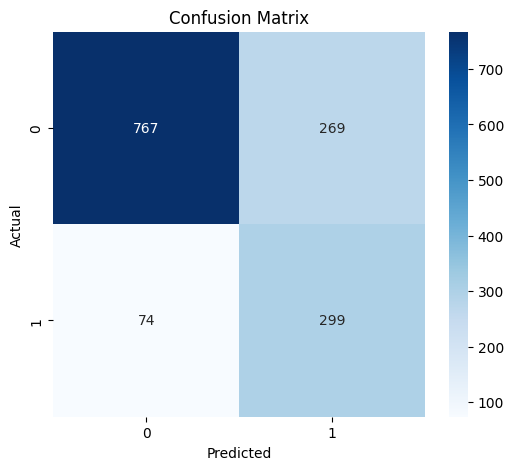

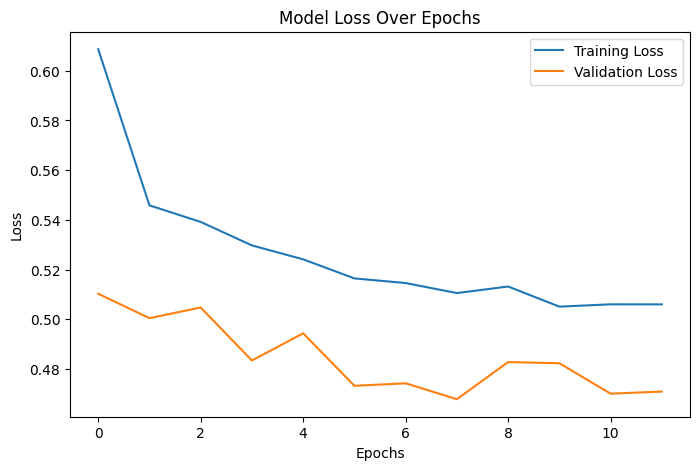

In [13]:
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get Probabilities
y_pred_probs = model.predict(X_test_scaled)

# 2. Convert to Class ( Threshold = 0.5)
y_pred = (y_pred_probs > 0.5).astype(int)

# 3. Report
print('Artificial Neural Network Model - Test Set Results')
print(classification_report(y_test, y_pred))

# 4. Confusion Matrix Visualization
plt.figure(figsize = (6 ,5))
sns.heatmap(confusion_matrix (y_test , y_pred),annot = True,fmt = 'd',cmap = 'Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Tuning 

The model was tuned to find the best combination of hyperparameters. After the optimization process finished, the following results were achieved:

*   **Best Validation F1 Score:** 0.6305
*   **Best Parameters Found:**
    *   Learning Rate (`lr`): 0.01
    *   Neurons: 128
    *   Dropout Rate: 0.2

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split 

# --- PREPARATION: Create a Validation Split ---
# Split X_train again to create a validation set (e.g., 20% of training data)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)



learning_rates = [0.01, 0.0005]
dropout_rates = [0.2, 0.7]
neuron_sizes = [64, 128, 256]

best_val_f1 = 0 
best_params = {}

print("Starting Hyperparameter Tuning...")

for lr in learning_rates:
    for dr in dropout_rates:
        for size in neuron_sizes:
            print(f"Testing: LR={lr}, Drop={dr}, Size={size}")
            K.clear_session() 

            # Pass 'size' to all layers implicitly via the new function signature
            build_model()
            temp_model = build_model(learning_rate=lr, dropout_rate=dr,neurons_layer1=size, neurons_layer2=size, neurons_layer3=size)
            
            # Train on the SUBSET of training data
            temp_model.fit(
                X_train_sub, y_train_sub, 
                epochs=10, batch_size=64, 
                verbose=0, class_weight=class_weights
            )
            
            # Predict on VALIDATION set (NOT TEST SET)
            y_pred_probs = temp_model.predict(X_val, verbose=0)
            y_pred = (y_pred_probs > 0.5).astype(int)
            
            # Calculate F1 on Validation
            from sklearn.metrics import f1_score
            val_f1 = f1_score(y_val, y_pred, pos_label=1)
            
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_params = {'lr': lr, 'neurons': size, 'dropout': dr}
                print(f"  -> New Best Validation F1: {best_val_f1:.4f}")

print(f"\nOptimization Finished.")
print(f"Best Validation F1: {best_val_f1}")
print(f"Best Parameters: {best_params}")

# --- FINAL STEP ---
# Now you retrain the best model on the FULL training set and test on X_test
print("\nRetraining best model on full data...")
final_model = build_model(best_params['lr'], best_params['dropout'], best_params['neurons'])
final_model.fit(X_train_scaled, y_train, epochs=20, verbose=0, class_weight=class_weights) 

# FINAL evaluation on X_test
final_probs = final_model.predict(X_test_scaled, verbose=0)
final_pred = (final_probs > 0.5).astype(int)
final_f1 = f1_score(y_test, final_pred, pos_label=1)

print(f"Final Test Set F1 Score: {final_f1:.4f}")

Starting Hyperparameter Tuning...
Testing: LR=0.01, Drop=0.2, Size=64


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  -> New Best Validation F1: 0.6067
Testing: LR=0.01, Drop=0.2, Size=128


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  -> New Best Validation F1: 0.6103
Testing: LR=0.01, Drop=0.2, Size=256


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  -> New Best Validation F1: 0.6397
Testing: LR=0.01, Drop=0.7, Size=64


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing: LR=0.01, Drop=0.7, Size=128


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing: LR=0.01, Drop=0.7, Size=256


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing: LR=0.0005, Drop=0.2, Size=64


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing: LR=0.0005, Drop=0.2, Size=128


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing: LR=0.0005, Drop=0.2, Size=256


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing: LR=0.0005, Drop=0.7, Size=64


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing: LR=0.0005, Drop=0.7, Size=128


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing: LR=0.0005, Drop=0.7, Size=256


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Optimization Finished.
Best Validation F1: 0.6396526772793053
Best Parameters: {'lr': 0.01, 'neurons': 256, 'dropout': 0.2}

Retraining best model on full data...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final Test Set F1 Score: 0.6379
